In [ ]:
# Run grid search for autoencoder.
# NOTE: the hyperparemeter search space is defined in grid_search.py
!python grid_search.py

## Load trained model

In [1]:
from Autoencoder import Autoencoder
import torch
import json


parameters = None
# extract autoencoder info from model_0_info.json
with open('trained_models/model_0_info.json') as f:
    training_params = json.load(f)
    print(training_params)


num_system_calls = 174
# initiate autoencoder model
model = Autoencoder(training_params['sequence_length'], num_system_calls, training_params['embedding_dim'], training_params['encoding_dim'], training_params['hidden_dim']) 

# load trained weights of best model
model.load_state_dict(torch.load('trained_models/model_0.pth')) # load trained weights of best model

{'train_loss': 0.14973887730063368, 'attack_loss': 0.8404842842500614, 'val_loss': 0.14118527177543866, 'atk_val_ratio': 4.760221032081214, 'hidden_dim': 8, 'embedding_dim': 10, 'encoding_dim': 4, 'batch_size': 128, 'learning_rate': 0.01, 'sequence_length': 5, 'total_epochs': 10}


<All keys matched successfully>

In [10]:
from grid_search_helper import load_all_attack_data, attack_test
from IPython.display import clear_output
import torch.nn as nn
%load_ext autoreload
%reload_ext autoreload
clear_output()


# loss threshold for anomaly/attack classification
# loss values above this threshold are considered attacks
threshold = training_params['atk_val_ratio'] * training_params['val_loss'] / 2
criterion = nn.MSELoss()
print('Attack/Validation loss ratio', training_params['atk_val_ratio'])
print('Validation loss', training_params['val_loss'])
print('Threshold', threshold)

# load and test attack data
attack_data_master_path = '../../../ADFA-LD-Dataset/ADFA-LD/Attack_Data_Master/'
attack_data_container = load_all_attack_data(attack_data_master_path, training_params['sequence_length'], training_params['batch_size'])
attack_loss_history_per_folder = attack_test(model, criterion, attack_data_container, predict=True)

# classify attacks based on loss threshold
attack_classification = {}
for folder_name, loss_history in attack_loss_history_per_folder.items():
    attack_classification[folder_name] = []
    for loss in loss_history:
        if loss > threshold:
            attack_classification[folder_name].append(1)
        else:
            attack_classification[folder_name].append(0)

# calculate accuracy of attack classification
total_attack = 0
correct_attack = 0

for folder_name, predictions in attack_classification.items():
    correct_attack += sum(predictions)
    total_attack += len(predictions)

print('Accuracy of attack classification: ', correct_attack/total_attack)

# TODO: mix attack data with normal data and test TPR and FPR of attack classification

Attack/Validation loss ratio 4.760221032081214
Validation loss 0.14118527177543866
Threshold 0.3360365500627726
Accuracy of attack classification:  0.9929839042509286


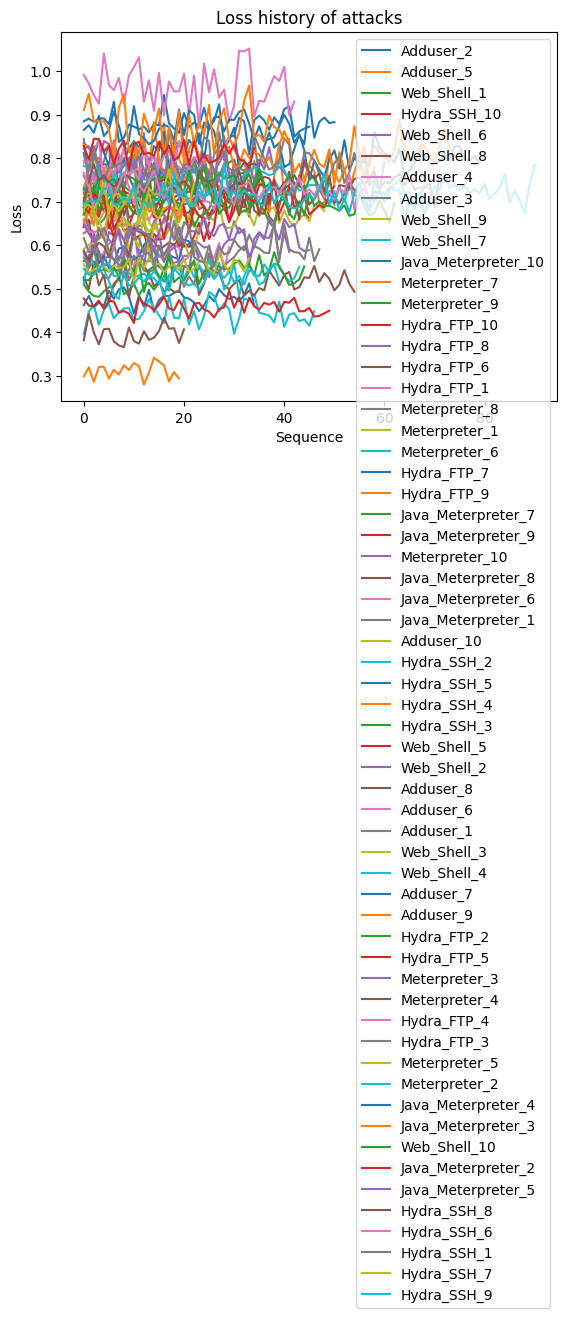

In [8]:
# plot loss history of each attack
import matplotlib.pyplot as plt
import numpy as np

for folder_name, loss_history in attack_loss_history_per_folder.items():
    plt.plot(np.arange(len(loss_history)), loss_history, label=folder_name)
plt.legend()
plt.xlabel('Sequence')
plt.ylabel('Loss')
plt.title('Loss history of attacks')
plt.show()
